In [ ]:
# import the necessary packages

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2 
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import numpy as np
import cv2
from google.colab import drive
from google.colab import files
import json
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
#function that receives two boxes and compute the IoU, is the same implementation developed in c++

def get_iou(bb1, bb2):

    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
#functions that will be used for plotting the accurancy and loss function of the model

def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

In [ ]:
#class for label binarizer that will be useful in the following procedure

class MyLabelBinarizer(LabelBinarizer):

    def transform(self, y):
        new_y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((new_y, 1-new_y))
        else:
            return new_y

In [ ]:
#dataset generation, starting from the images loaded on Google Drive


#mount drive and save the label file (label_multi.json) 
drive.mount('/content/drive')
with open('/content/drive/MyDrive/dataset_boats/label_multi.json') as json_file:
    json_file = json.load(json_file)

#define the lists of lables and images
i=1
train_images=[]
train_labels=[]

for row in json_file:

  #max false represent the number of false regions extract from an image, initially is settled equal to 2 since the first 1150 images are surrounded by sea
  if i < 1150:
    max_false = 16
  else:
    max_false = 2

  i=i+1

  #take the path of the image save on drive and read it using the library opencv cv2
  image_path = "/content/drive/MyDrive/dataset_boats/train/" + row['External ID']
  cv_image = cv2.imread(image_path)
  input_img = cv_image.copy()

  box_values=[]
  for col in row['Label']['objects']:
    if(len(row['Label']) != 0):

      # calculate the 2 points of a box by extracting from the file label
      x_start = int(col['bbox']['left'])
      y_start = int(col['bbox']['top'])
      x_end = int(col['bbox']['left'] + col['bbox']['width'])
      y_end = int(col['bbox']['top'] + col['bbox']['height'])

      #extract the image from the input image and resize with the value required for the model
      region = cv2.resize(input_img[y_start:y_end,x_start:x_end], (224,224), interpolation = cv2.INTER_AREA)
      train_images.append(region)

      #label the region
      train_labels.append(1)

      #save the box values
      box_values.append({"x1":x_start,"x2":x_end,"y1":y_start,"y2":y_end})


  #initiliaze and compute the selective search for finding the false negative inside the images
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(cv_image)
  ss.switchToSelectiveSearchFast()
  ssresults = ss.process()


  false_counter = 0
  for num_regions,result in enumerate(ssresults):

    #proced until the number of regions is reached (5000) or the number of false negative for image is complete
    if num_regions < 5000 and false_counter < max_false:

      #now, it is important verifying that if the region chosen is not a boat
      continue_flag = 0
      for box in box_values:
        x, y, w, h = result
        iou = get_iou(box,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
        if iou > 0.1:
          continue_flag = 1

      if continue_flag == 1:
        continue

      #check if the image is too small and put in the train images as we have done previously
      if iou < 0.05 and h*w > 6000:
        region = cv2.resize(input_img[y:y+h,x:x+w], (224,224), interpolation = cv2.INTER_AREA)
        train_images.append(region)
        train_labels.append(0)
        false_counter += 1

print("Training set size:")
print(len(train_images))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training set size:
15502


In [ ]:
#from list to array
X = np.array(train_images)
y = np.array(train_labels)

#load the model Mobile Net
model = MobileNetV2(weights='imagenet', include_top=True)

#modify the network to have 2 outputs 
input = model.layers[-2].output
output = Dense(2, activation="softmax")(input)
model_final = Model(inputs = model.input, outputs = output)

#compile and set the Adam optimizer with learning rate 
model_final.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate=0.0001), metrics=["accuracy"])

#print the model
model_final.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
#label binarization 
label_bin = MyLabelBinarizer()
y =  label_bin.fit_transform(y)

#split the training/validation/test set 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.8)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.10)

In [ ]:
#image generation in oreder to have more images and rotational invariant
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90) 
X_train = trdata.flow(x=X_train, y=y_train)

In [ ]:
#set the Early stopping approch in order to avoid the overfitting and then train the model 

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
history = model_final.fit(X_train ,steps_per_epoch= 60, epochs= 50, callbacks=[early_stopping], validation_data=(X_val, y_val))

Epoch 1/50
60/60 [==============================] - 46s 558ms/step - loss: 0.2763 - accuracy: 0.8735 - val_loss: 0.6256 - val_accuracy: 0.6516
Epoch 2/50
60/60 [==============================] - 30s 490ms/step - loss: 0.0736 - accuracy: 0.9675 - val_loss: 0.2342 - val_accuracy: 0.9484
Epoch 3/50
60/60 [==============================] - 29s 485ms/step - loss: 0.0280 - accuracy: 0.9884 - val_loss: 0.2311 - val_accuracy: 0.9323
Epoch 4/50
60/60 [==============================] - 30s 491ms/step - loss: 0.0379 - accuracy: 0.9841 - val_loss: 0.1682 - val_accuracy: 0.9581
Epoch 5/50
60/60 [==============================] - 29s 484ms/step - loss: 0.0263 - accuracy: 0.9909 - val_loss: 0.3466 - val_accuracy: 0.9387
Epoch 6/50
60/60 [==============================] - 30s 494ms/step - loss: 0.0204 - accuracy: 0.9931 - val_loss: 0.3561 - val_accuracy: 0.9387
Epoch 7/50
60/60 [==============================] - 29s 484ms/step - loss: 0.0200 - accuracy: 0.9916 - val_loss: 0.1435 - val_accuracy: 0.9613

388/388 - 29s - loss: 0.0834 - accuracy: 0.9803
accuracy: 98.03%


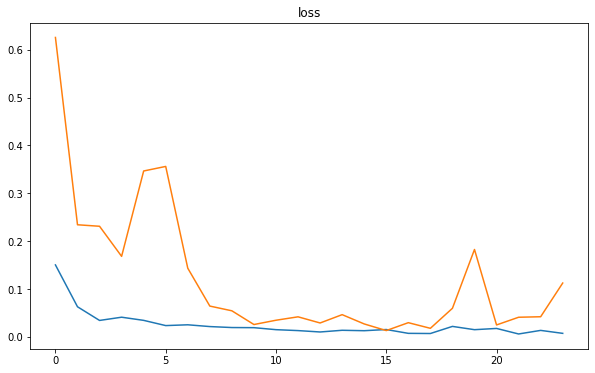

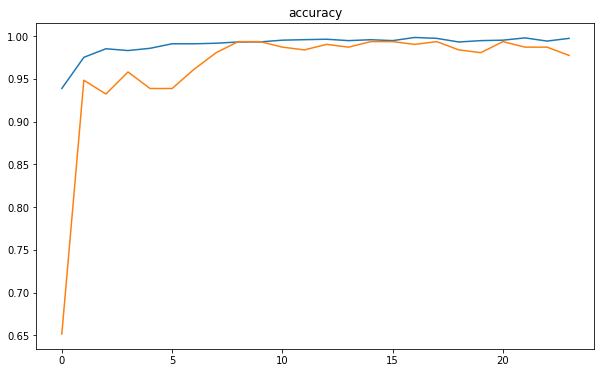

In [ ]:
#plotting the result and print the score of the test 

plot_loss(history)
plot_accuracy(history)

scores = model_final.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model_final.metrics_names[1], scores[1]*100))

In [ ]:
#Save the model 

model_final.save("/content/drive/MyDrive/dataset_boats/model.h5", overwrite=True)

In [ ]:
import tensorflow as tf

#reload the model and save it as .pb file used for c++ neural network

model = tf.keras.models.load_model('/content/drive/MyDrive/dataset_boats/model.h5')
full_model = tf.function(lambda inputs: model(inputs))    
full_model = full_model.get_concrete_function(tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction    
frozen = convert_variables_to_constants_v2(full_model)    
frozen.graph.as_graph_def()

# Save frozen graph from frozen ConcreteFunction to hard drive    
tf.io.write_graph(graph_or_graph_def=frozen.graph, logdir="/content/drive/MyDrive/dataset_boats/", name="model.pb", as_text=False)

'/content/drive/MyDrive/dataset_boats/model.pb'

In [ ]:
#reload the model.pb and save it as .pbtxt used for c++ neural network

with open('/content/drive/MyDrive/dataset_boats/model.pb', 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

with K.get_session() as session:
    session.graph.as_default()
    tf.import_graph_def(graph_def, name='')

for i in reversed(range(len(graph_def.node))):
    if graph_def.node[i].op == 'Const':
        del graph_def.node[i]
    for attr in ['T', 'data_format', 'Tshape', 'N', 'Tidx', 'Tdim','use_cudnn_on_gpu', 'Index', 'Tperm', 'is_training','Tpaddings']:
        if attr in graph_def.node[i].attr:
             del graph_def.node[i].attr[attr]

# Save stripped model
tf.io.write_graph(graph_def, logdir="/content/drive/MyDrive/dataset_boats/", name="model.pbtxt", as_text=True)

'/content/drive/MyDrive/dataset_boats/model.pbtxt'